### 1. Výpočet tepové frekvence z EKG signálu

In [47]:
import wfdb
from wfdb import Record, Annotation
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
import pandas as pd

In [48]:
plt.style.use("dark_background")

In [49]:
# Vstupní data: https://physionet.org/content/butqdb/1.0.0/
# Testovací databáze: https://physionet.org/content/nsrdb/1.0.0/

In [50]:
ecg: Record = wfdb.rdrecord("100001_ECG")
info = [
    ["Název souboru", ecg.record_name],
    ["Vzorkovací frekvence (Hz)", ecg.fs],
    ["Délka signálu (vzorky)", ecg.sig_len],
    ["Počet kanálů", ecg.n_sig],
    ["Názvy kanálů", ", ".join(ecg.sig_name)],
    ["Jednotky pro každý kanál", ", ".join(ecg.units)],
]
info_df = pd.DataFrame(info, columns=["Informace", "Hodnota"])
display(info_df)

,Informace,Hodnota
0,Název souboru,100001_ECG
1,Vzorkovací frekvence (Hz),1000
2,Délka signálu (vzorky),87087000
3,Počet kanálů,1
4,Názvy kanálů,ECG
5,Jednotky pro každý kanál,uV


In [62]:
class PanTompkinsDetector:
    def __init__(self, ecg_signal: np.ndarray, fs: float):
        self.fs = fs
        self.ecg_signal = ecg_signal

    def _center_signal(self, signal: np.ndarray) -> np.ndarray:
        return signal - np.mean(signal)

    def _low_pass_filter(self, signal: np.ndarray, cutoff_hz=15, order=2) -> np.ndarray:
        nyquist_freq = 0.5 * self.fs
        b, a = butter(order, cutoff_hz / nyquist_freq, btype="low")
        return filtfilt(b, a, signal)

    def _high_pass_filter(self, signal: np.ndarray, cutoff_hz=1, order=2) -> np.ndarray:
        nyquist_freq = 0.5 * self.fs
        b, a = butter(order, cutoff_hz / nyquist_freq, btype="high")
        return filtfilt(b, a, signal)

    def _derivative_filter(self, signal: np.ndarray) -> np.ndarray:
        kernel = np.array([2, 1, 0, -1, -2]) / 8.0
        return np.convolve(signal, kernel, mode="same")

    def _squaring(self, signal: np.ndarray) -> np.ndarray:
        return np.power(signal, 2)

    def _moving_window_integration(
        self, signal: np.ndarray, window_ms=150
    ) -> np.ndarray:
        MS_IN_SECOND = 1000.0
        window_size = int(self.fs * (window_ms / MS_IN_SECOND))
        kernel = np.ones(window_size) / window_size
        return np.convolve(signal, kernel, mode="same")

    def _detect_r_peaks(self, signal_integrated: np.ndarray) -> np.ndarray:
        DISTANCE_SECONDS = 0.2
        HEIGHT_RATIO = 0.3
        min_distance = int(DISTANCE_SECONDS * self.fs)
        height_threshold = HEIGHT_RATIO * np.max(signal_integrated)
        peaks, _ = find_peaks(
            signal_integrated, distance=min_distance, height=height_threshold
        )
        return peaks

    def _compute_heart_rate_bpm(self, r_peaks_indices: np.ndarray) -> float:
        SECONDS_PER_MINUTE = 60.0
        signal_length_seconds = len(self.ecg_signal) / self.fs
        bpm = (len(r_peaks_indices) / signal_length_seconds) * SECONDS_PER_MINUTE
        return bpm

    def _plot_signal(self, title: str, signal: np.ndarray):
        plt.figure(figsize=(18, 5))
        plt.title(title)
        plt.plot(signal, label=title, color="cyan")
        plt.xlabel("Vzorek [s]")
        plt.ylabel("Amplituda [µV]")
        plt.grid(which="both", linestyle="--", alpha=0.2)
        plt.show()

    def _plot_detected_r_peaks(
        self, signal_integrated: np.ndarray, r_peaks_indices: np.ndarray
    ):
        plt.figure(figsize=(18, 5))
        plt.title("Detekované R-peaky na integrovaném signálu")
        plt.plot(signal_integrated, label="Integrovaný signál", color="cyan")
        plt.plot(
            r_peaks_indices,
            signal_integrated[r_peaks_indices],
            "rx",
            label="R-peaks",
        )
        plt.xlabel("Vzorek [s]")
        plt.ylabel("Amplituda [µV]")
        plt.grid(which="both", linestyle="--", alpha=0.2)
        plt.legend()
        plt.show()

    def solve(self):
        """
        Spustí celý Pan-Tompkins řetězec:
        1) Centralizace
        2) Low-pass filtr
        3) High-pass filtr
        4) Derivace
        5) Umocnění (Squaring)
        6) Posuvné integrační okno
        7) Detekce R-peaks + výpočet tepové frekvence
        8) Vrací metadata pro další analýzu či vykreslení
        """
        signal_centered = self._center_signal(self.ecg_signal)
        self._plot_signal("1) Signál po centralizaci", signal_centered)

        signal_lowpass = self._low_pass_filter(signal_centered)
        self._plot_signal("2) Signál po low-pass filtru", signal_lowpass)

        signal_highpass = self._high_pass_filter(signal_lowpass)
        self._plot_signal("3) Signál po high-pass filtru", signal_highpass)

        signal_derivative = self._derivative_filter(signal_highpass)
        self._plot_signal("4) Signál po derivačním filtru", signal_derivative)

        signal_squared = self._squaring(signal_derivative)
        self._plot_signal("5) Signál po umocnění", signal_squared)

        signal_integrated = self._moving_window_integration(signal_squared)
        self._plot_signal("6) Signál po posuvném integračním oknu", signal_integrated)

        r_peaks_indices = self._detect_r_peaks(signal_integrated)
        self._plot_detected_r_peaks(signal_integrated, r_peaks_indices)

        bpm = self._compute_heart_rate_bpm(r_peaks_indices)

        return {
            "centered": signal_centered,
            "lowpass": signal_lowpass,
            "highpass": signal_highpass,
            "derivative": signal_derivative,
            "squared": signal_squared,
            "integrated": signal_integrated,
            "r_peaks_indices": r_peaks_indices,
            "heart_rate_bpm": bpm,
        }

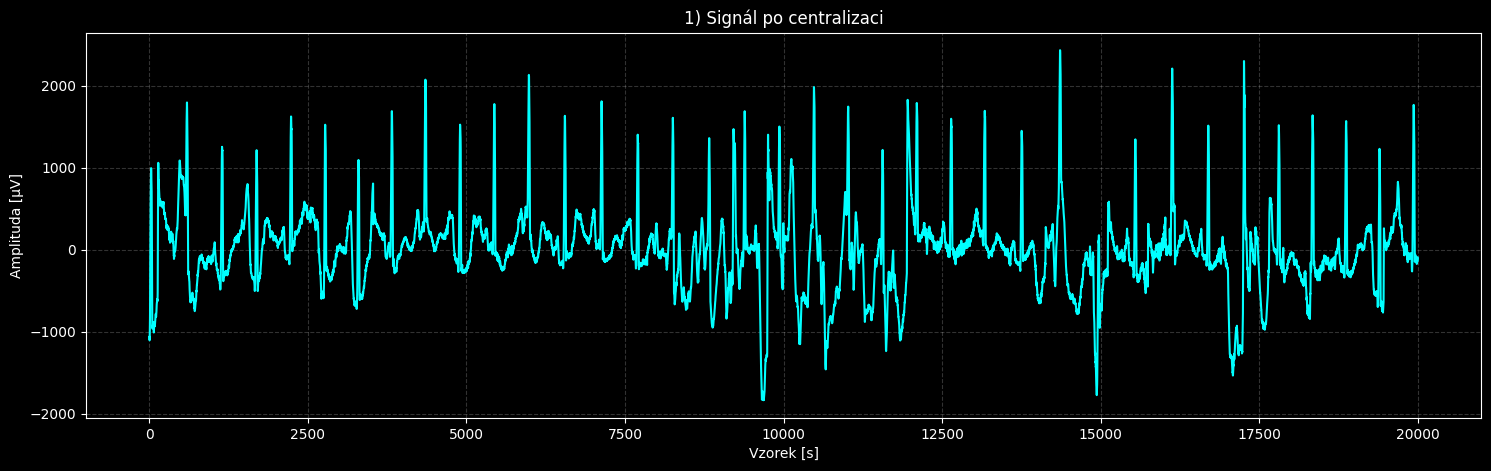

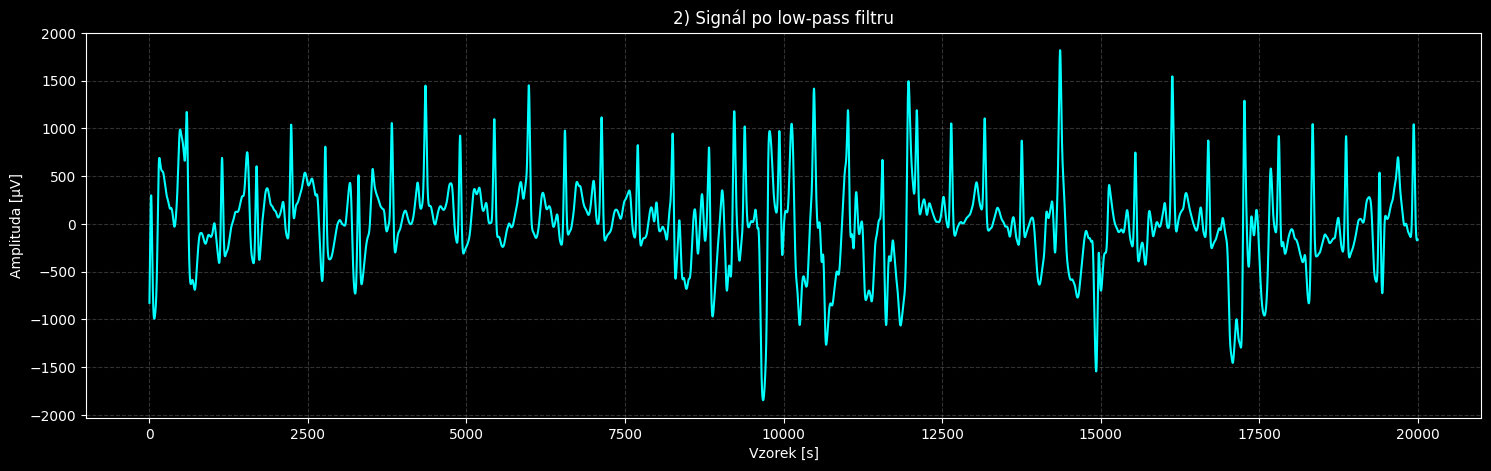

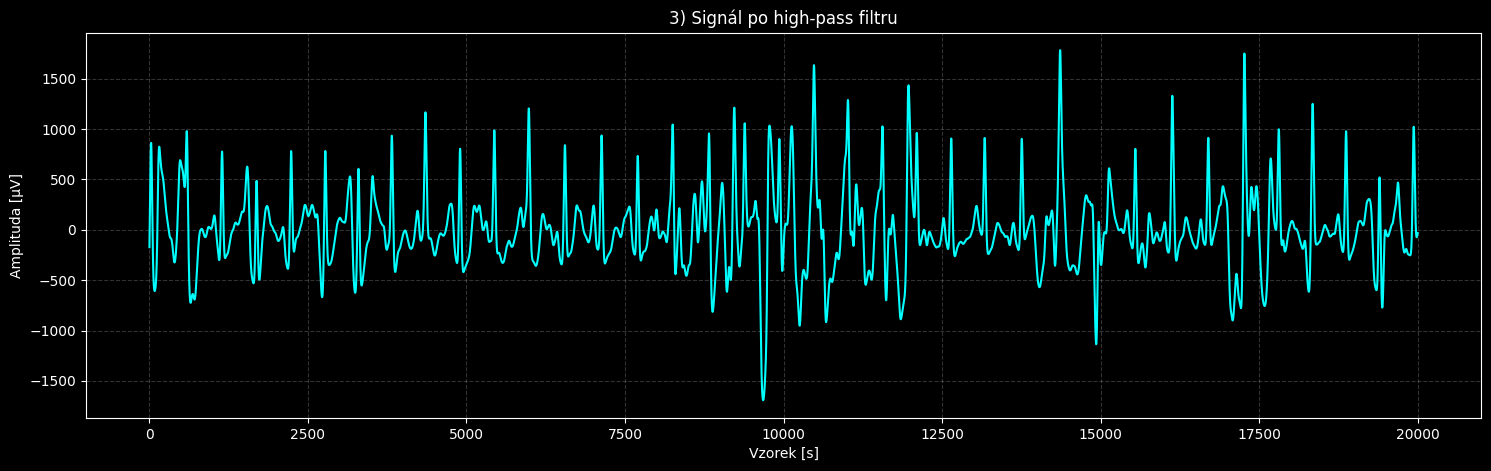

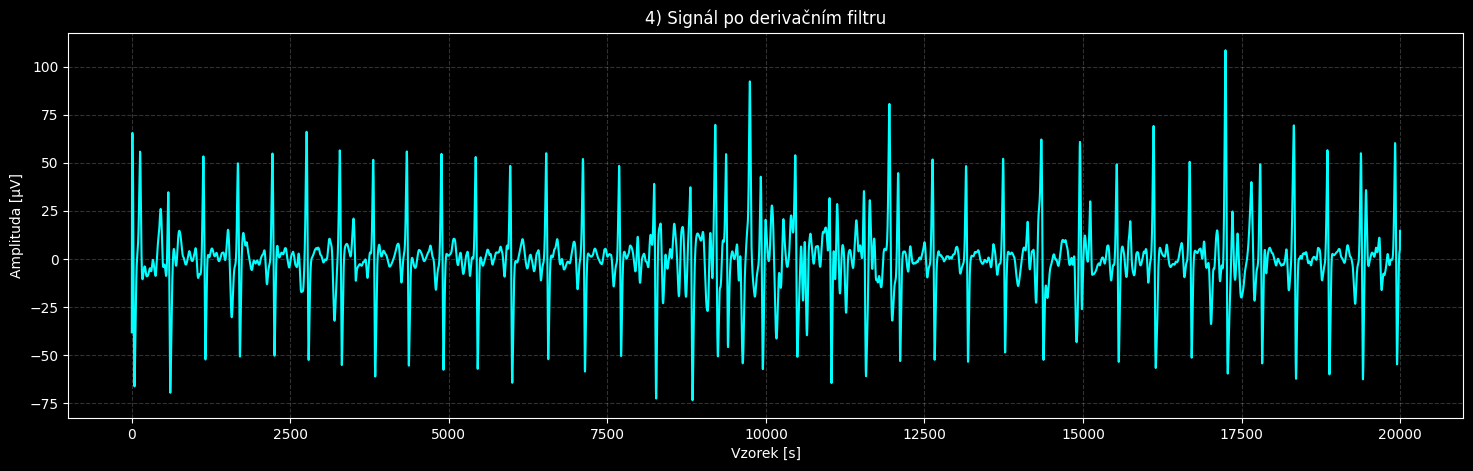

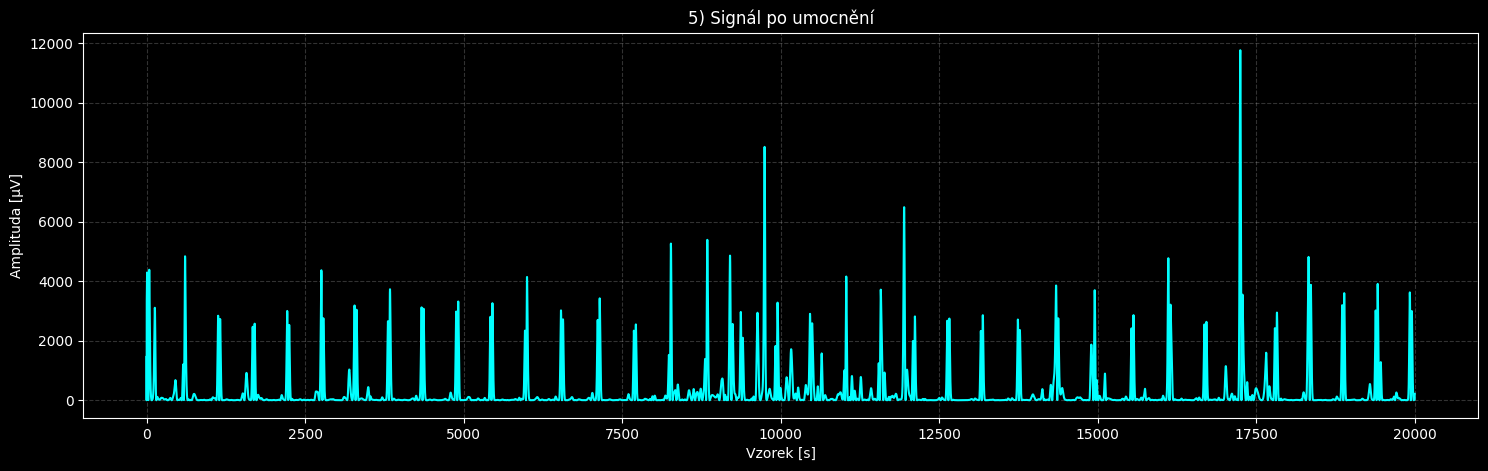

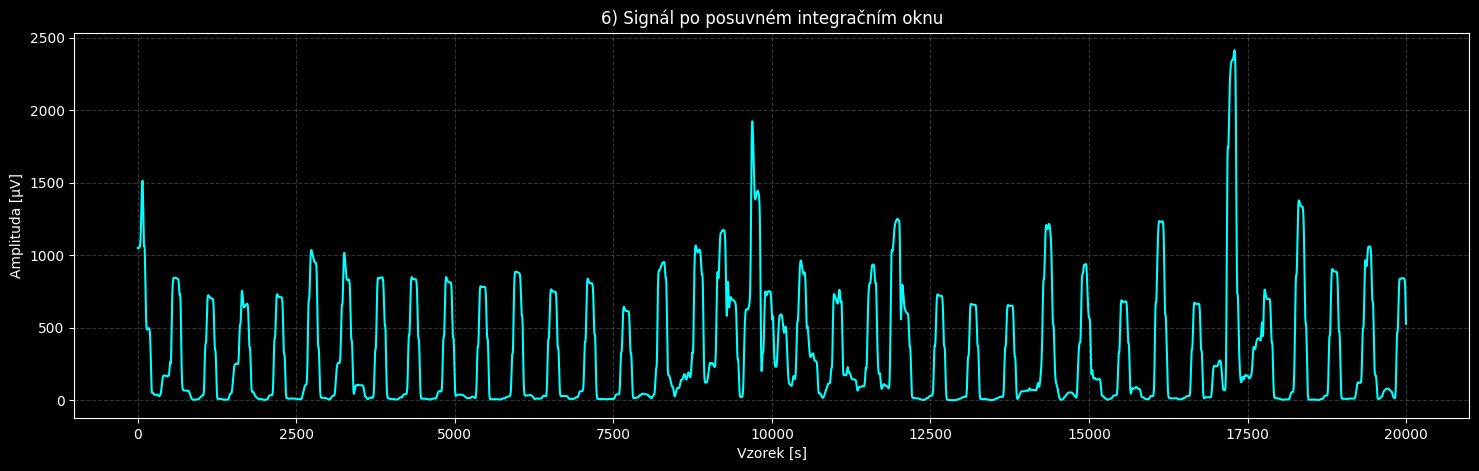

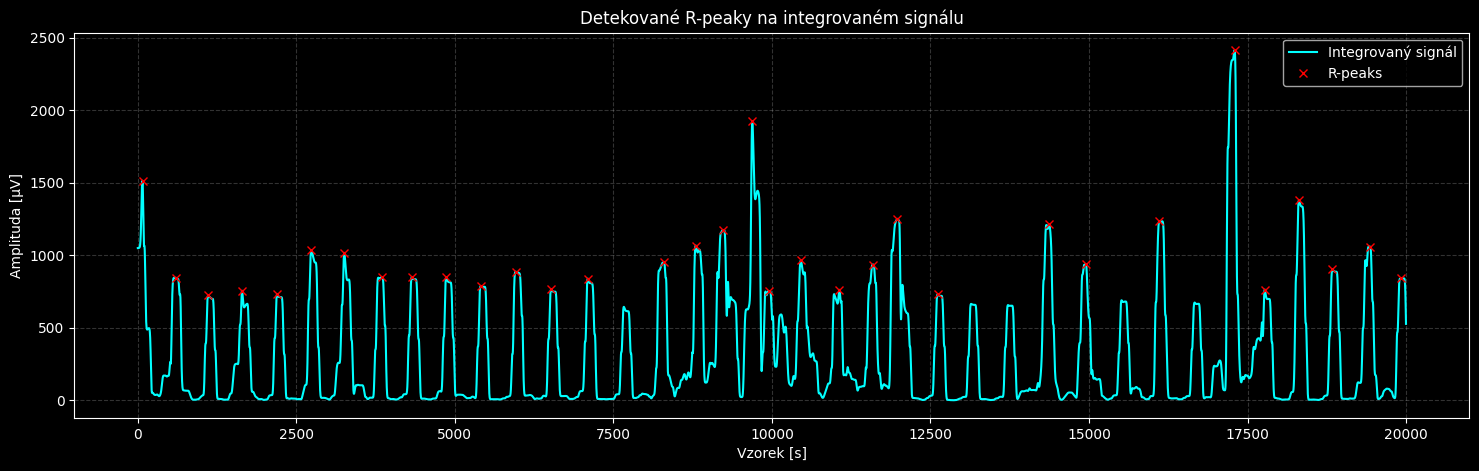

Počet detekovaných R-peaků: 33
Odhadovaná tepová frekvence (BPM): 99.0


In [63]:
ecg_100001: Record = wfdb.rdrecord("100001_ECG", sampfrom=40000, sampto=60000)
ecg_signal: np.ndarray = ecg_100001.p_signal.squeeze()
fs: float = ecg_100001.fs

detector = PanTompkinsDetector(ecg_signal, fs)
results = detector.solve()

print(f"Počet detekovaných R-peaků: {len(results['r_peaks_indices'])}")
print(f"Odhadovaná tepová frekvence (BPM): {results['heart_rate_bpm']}")